## 레버리지와 아웃라이어

- 레버리지 (Leverage)
- 레버리지 계산 (StatsModel)
- 레버리지의 영향
- 아웃라이어 (Outlier)
- 표준화 잔차
- Cook's Distance

---

### 00. Setting

In [1]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


---

### 01. 레버리지 (Leverage)

#### 1. 정의

- 실제 종속변수값 $y$가 예측치 (predicted target) $\hat{y}$에 미치는 영향을 나타낸 값


- 레버리지는 실제의 결과값 $y_i$이 예측값 $\hat{y}_i$에 미치는 영향, 즉 예측점을 자기 자신의 위치로 끌어 당기는 정도

#### 2. 의미

$  \hat{y} =  Hy $ 에서 행렬 $H$의 성분을 $h_{ij}$라고 하면 실제 결과값 $y_i$과 예측값 $\hat{y}_i$은 다음과 같은 관계를 가짐

$$\hat{y}_i = h_{i1} y_1 + h_{i2} y_2 + \cdots + h_{ii} y_i + \cdots + h_{iN} y_N $$

$h_{ii}$ 값이 1이 되고 나머지 성분들이 모두 0이 된다면 모든 표본 데이터에 대해 실제 결과값과 예측값이 일치 (현실적으로 발생 X)

$$ h_{ii} = 1, h_{ij} = 0 \; (\text{for } i \neq j) \;\; \rightarrow \;\; \hat{y}_i = y_i $$

#### 3. 수학적 정의

$$ h_{ii}=(H)_{ii}\;\;(영향도\;행렬의\;대각성분\;h_{ii})$$

#### 4. 특징

1) 1보다 같거나 작은 양수 혹은 0

$$  0 \leq h_{ii} \leq 1 $$

2) 레버리지의 합은 모형에 사용된 모수의 갯수 $K$와 같음. 모수에는 상수항도 포함되므로 상수항이 있는 1차원 모형에서는 $K = 2$가 됨

$$  \text{tr}(H) = \sum_i^N h_{ii} = K $$

- 두가지 성질로부터 레버리지 값은 $N$개의 데이터에 대한 레버리지값은 양수이고 그 합이 $K$가 된다는 것을 알 수 있음 


- 즉, $K$라고 하는 값을 $N$개의 변수가 나누어 가지는 것과 같음


- 현실적으로 데이터의 갯수 $N$는 모수의 갯수 $K$보다 훨씬 많기 때문에 위에서 언급한 모든 레버리지 값이 동시에 1이 되는 것은 불가능

3) 위 식을 이용하면 레버리지의 평균값을 구할 수 있음

$$ h_{ii} \approx \dfrac{K}{N} $$

$\rightarrow$ 일반적으로 평균값의 2 ~ 4배보다 레버리지 값이 크면 레버리지가 크다고 가정

---

### 02. 레버리지 계산 (StatsModel)

레버리지 값은 RegressionResults 클래스의 get_influence 메서드를 이용 (영향도 정보 객체를 구하기)

In [2]:
from sklearn.datasets import make_regression

# 100개의 데이터 생성
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20, 
                              coef=True, random_state=1)

In [3]:
# 레버리지가 높은 가상의 좌표 생성
data_100 = (4, 300)
data_101 = (3, 150)

In [4]:
# 기존의 데이터에 추가
X0 = np.vstack([X0, np.array([data_100[:1], data_101[:1]])])
X = sm.add_constant(X0)
y = np.hstack([y, [data_100[1], data_101[1]]]) # 일부러 포인트 추가함

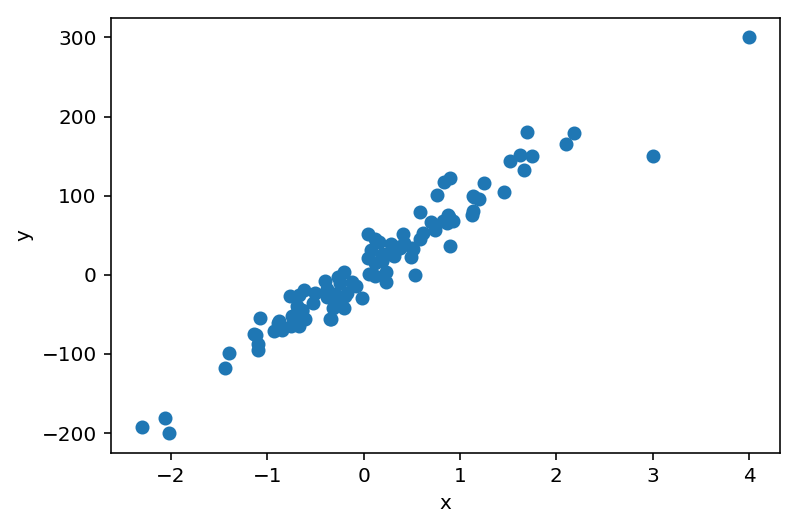

In [5]:
# 시각화 (Scatter plot)
plt.scatter(X0, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [6]:
# 추가된 데이터를 통해 분석
model = sm.OLS(pd.DataFrame(y), pd.DataFrame(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1464.
Date:                Sun, 04 Mar 2018   Prob (F-statistic):           1.61e-61
Time:                        10:44:08   Log-Likelihood:                -452.71
No. Observations:                 102   AIC:                             909.4
Df Residuals:                     100   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              3.2565      2.065      1.577      0.1

In [7]:
# result에서 get_influence호출
influence = result.get_influence()
hat = influence.hat_matrix_diag

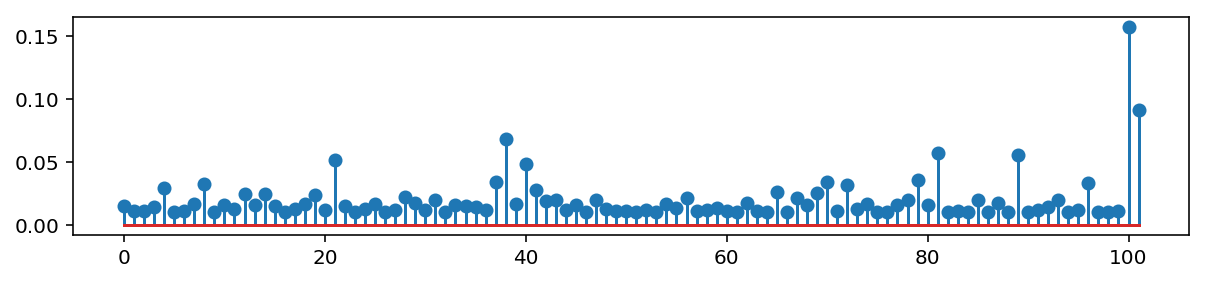

In [8]:
plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

$\rightarrow$ Sample = 100, Parameter = 2 따라서 평균적으로 0.02가 나오야 함

In [9]:
# 레버리지의 합이 parameter와 같아야 함
print("hat.sum() =", hat.sum())

hat.sum() = 2.0000000000000004


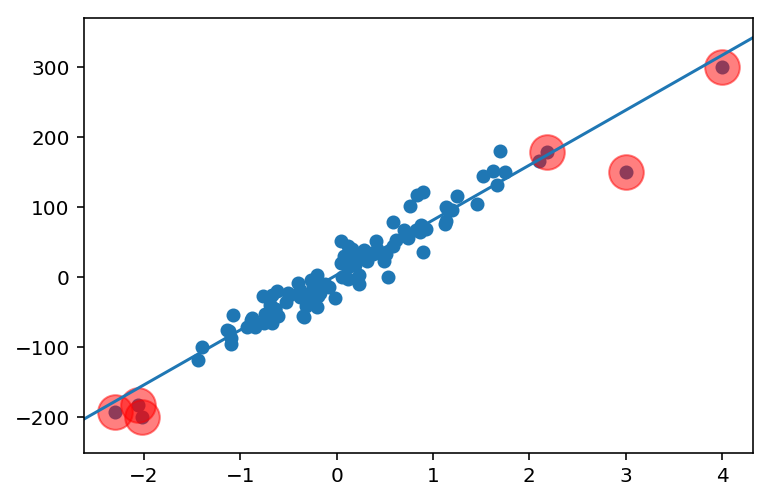

In [10]:
# 레버리지가 큰 값들을 표시
ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, ax=ax)

# 레버리지 값이 0.05 이상인 값을 표시
idx = hat > 0.05
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
plt.show()

레버리지 해석

- $x$가 4일때 300인 값은 하나, 이는 x가 4일때 300이 곧 법칙이 될 수 있다는 의미 


- 이 숫자의 영향력은 엄청나다는 것이고, 그만큼 레버리지가 크다는 의미


- 위 그림에서 데이터가 무리지어 있지 않고 단독으로 존재할수록 레버리지가 커짐을 알 수 있음 (떨어져 있는 것들)

---

### 03. 레버리지의 영향

#### 1. 레버리지가 큰 데이터를 포함하는 경우

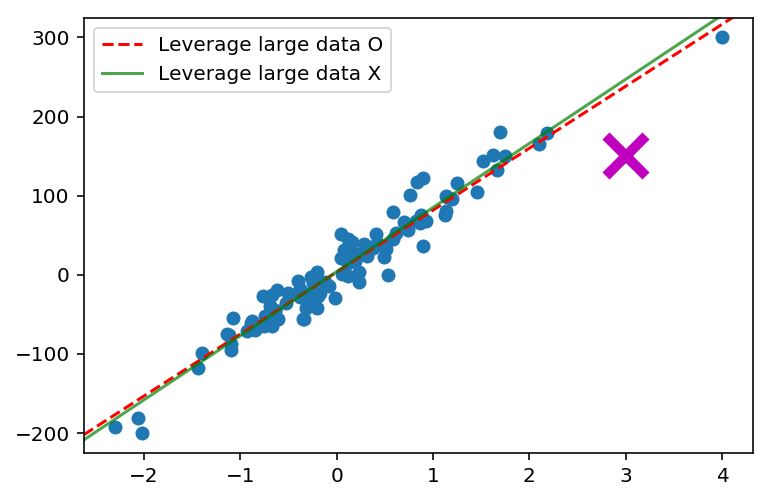

In [11]:
model2 = sm.OLS(y[:-1], X[:-1])
result2 = model2.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result2,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-1], y[-1], marker='x', c="m", ms=20, mew=5)
plt.legend(["Leverage large data O", "Leverage large data X"],
           loc="upper left")
plt.show()

$\rightarrow$ 레버리지가 큰 데이터는 포함되거나 포함되지 않는가에 따라 모형에 주는 영향이 큼

$\therefore\;$  레버리지가 큰 데이터는 없애는게 좋음

#### 2. 레버리지가 작은 데이터를 포함하는 경우

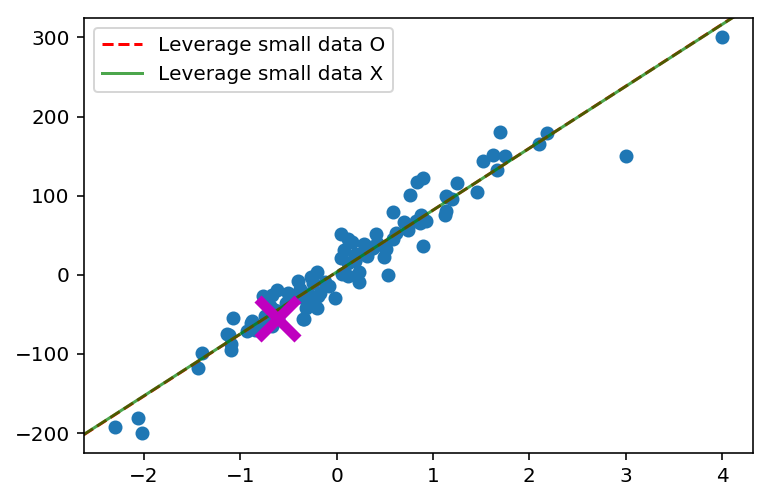

In [12]:
model3 = sm.OLS(y[1:], X[1:])
result3 = model3.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, 
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result3, 
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[0], y[0], marker='x', c="m", ms=20, mew=5)
plt.legend(["Leverage small data O", "Leverage small data X"], 
           loc="upper left")
plt.show()

$\rightarrow$ 레버리지가 작은 데이터는 포함되던지 안되던지 모형이 별로 달라지지 않음

#### 3. 레버리지가 크더라도 오차가 작은 경우

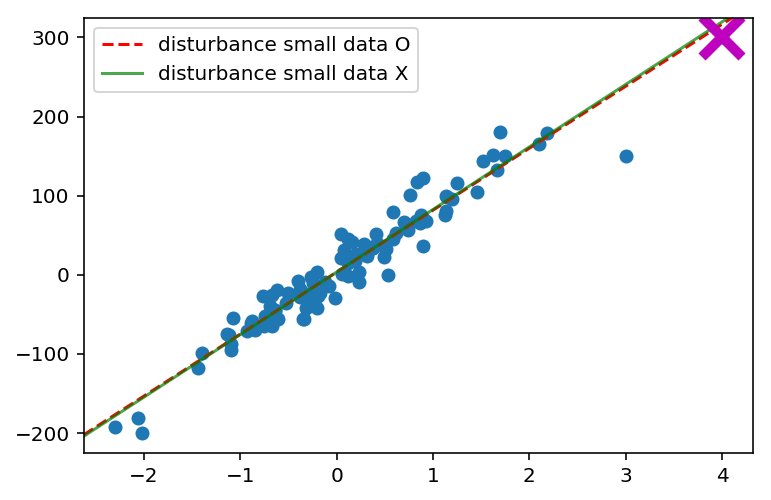

In [13]:
idx = np.array(list(range(100)) + [101])
model4 = sm.OLS(y[idx], X[idx, :])
result4 = model4.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, 
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result4, 
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-2], y[-2], marker='x', c="m", ms=20, mew=5)
plt.legend(["disturbance small data O", "disturbance small data X"], 
           loc="upper left")
plt.show()

$\rightarrow$ 포함되거나 포함되지 않거나 모형이 별로 달라지지 않음

---

### 04. 아웃라이어 (Outlier)

#### 1. 정의

모형에서 설명하고 있는 데이터와 동떨어진 값을 가지는 데이터, 즉 잔차가 큰 데이터

#### 2. 특징

 잔차의 크기는 독립 변수의 영향을 받으므로 아웃라이어를 찾으러면 이 영향을 제거한 표준화된 잔차를 계산해야 함

---

### 05. 표준화 잔차 

- 잔차를 레버리지와 잔차의 표준 편차로 나누어 동일한 표준 편차를 가지도록 스케일링한 것


- standardized residual, normalized residual, studentized residual라고도 함

#### 1. 개별적인 잔차의 표준편차

1) 잔차의 분산

$$ e = (I - H) \epsilon $$

$$\begin{eqnarray}
\text{Var}[e] 
&=& \text{E}[M \epsilon\epsilon^T M^T] \\\\
&=& M \text{E}[\epsilon\epsilon^T] M^T \\\\
&=& M \sigma^2 I M^T \\\\
&=& \sigma^2MM^T \\\\
&=& \sigma^2MM (\because M=대칭행렬)\\\\
&=& \sigma^2M\;\;(\because MM=M)\\\\
&=& \sigma^2(I - H) \\\\
\end{eqnarray}$$

2) 대각 성분만을 통해 개별적인 잔차의 분산 구하기

$$ \text{Var}[e_i] = \sigma^2 (1 - h_{ii}) $$ 

$\rightarrow$ 오차의 표준 편차는 모든 표본에 대해 같지만, 개별적인 잔차의 표준편차는 레버리지에 따라 달라지는 것을 알 수 있음

3) 오차의 분산은 알지 못하므로 잔차 분산으로부터 추정

$$\text{Est.Var}[e_i] = s^2 (1 - h_{ii})$$

4) 이 식에서  $s$는 다음과 같이 구한 오차의 표준편차 추정값

$$ s^2 = \dfrac{e^Te}{N-K} = \dfrac{RSS}{N-K} $$

5) 표준화 잔차 : 잔차를 레버리지와 잔차의 표준 편차로 나누어 동일한 표준 편차를 가지도록 스케일링

$$ r_i = \dfrac{e_i}{s\sqrt{1-h_{ii}}} $$

#### 2. StatsModels를 이용한 표준화 잔차 계산

1) 데이터의 잔차를 표시

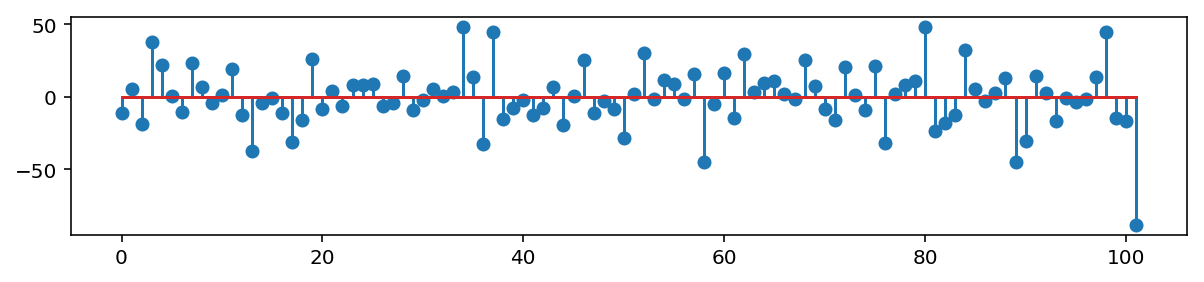

In [14]:
# 잔차는 RegressionResult 객체의 resid 속성에 있음
plt.figure(figsize=(10, 2))
plt.stem(result.resid)
plt.show()

2) 표준화 잔차를 표시

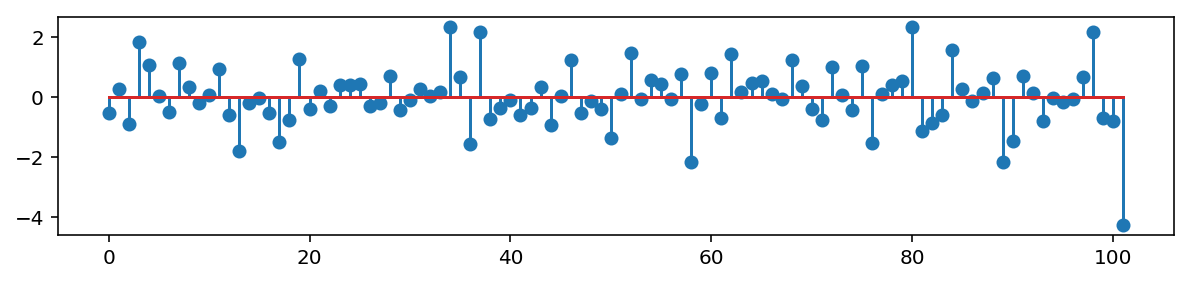

In [15]:
# 표준화 잔차는 resid_pearson 속성
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.show()

$\rightarrow$ 보통 표준화 잔차가 2~4보다 크면 아웃라이어

---

### 06. Cook's Distance

#### 1. 정의

- 회귀 분석에선 잔차의 크기가 큰 데이터가 아웃라이어가 되는것을 앞에서 확인


- 이 중에서도 주로 관심을 가지는 것은 레버리지와 잔차의 크기가 모두 큰 데이터


- 잔차와 레버리지를 동시에 보기 위한 기준을 Cook's Distance로 실행

$$ D_i = \frac{r_i^2}{\text{RSS}}\left[\frac{h_{ii}}{(1-h_{ii})^2}\right] $$

$\rightarrow$ 레버리지가 커지거나 잔차의 크기가 커지면 Cook's Distance 값이 커짐

#### 2. Fox' Outlier Recommendation

Cook's Distance가 다음과 같은 기준값보다 클 때 아웃라이어로 판단하자는 것

$$ D_i > \dfrac{4}{N − K - 1} $$

#### 3. 모든 데이터의 레버리지와 잔차를 동시에 보기

1) plot_leverage_resid2 명령을 사용 (점으로 표시)

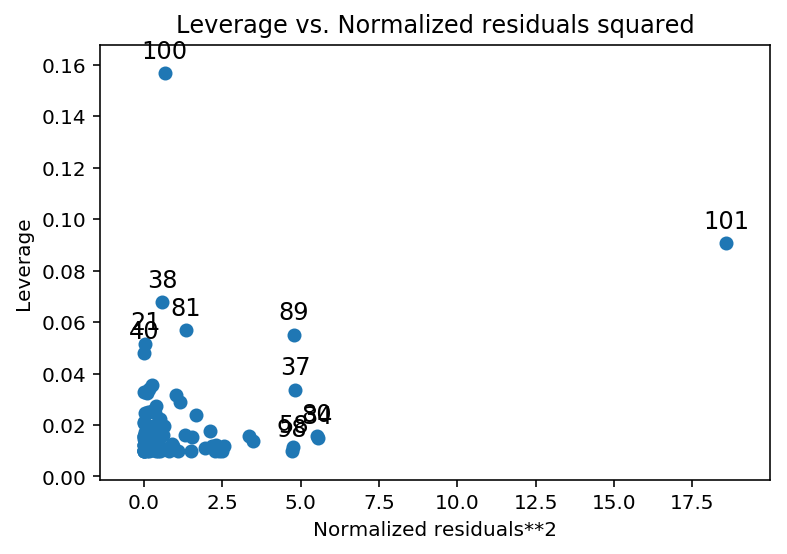

In [16]:
sm.graphics.plot_leverage_resid2(result)
plt.show()

2) plot_leverage_resid2 명령을 사용 (버블로 표시)

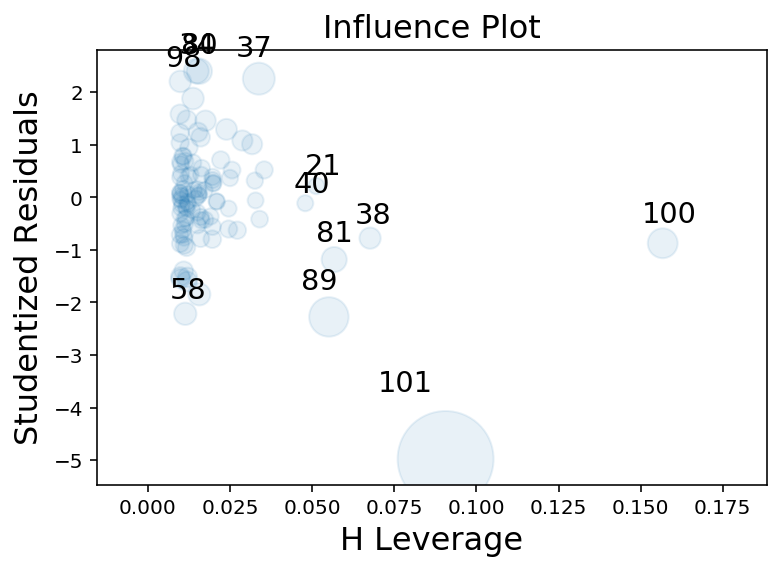

In [17]:
sm.graphics.influence_plot(result, plot_alpha=0.1)
plt.show()

$\rightarrow$ 위의 plot과 다르게 residuals 값이 제곱되어 있지 않다는 것을 유의해야함

3) Cook's Distance 기준으로 표시

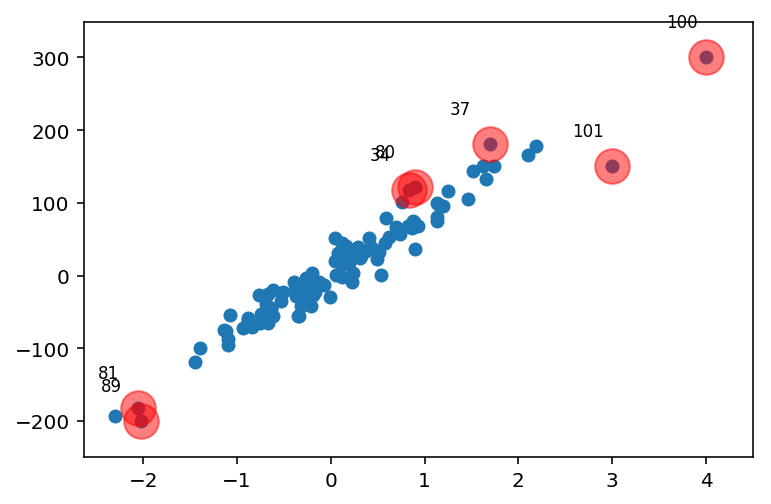

In [18]:
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(y) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(X0, y)
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(X0[idx], y[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()